In [1]:
!pip install scikit-learn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
#from tensorflow.keras import Sequential
#from tensorflow.keras import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, Reshape, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras import metrics

try:
    from keras.utils import np_utils
except:
    pass
try:
    from tensorflow.keras import utils as np_utils
except:
    pass

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [2]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

# Keras and Tensorflow Optimizations

There are several things that we can do to make our networks a bit better. Unfortunately for much of this there aren't definitive answers for "what is the best choice", so we do have to do some trial and error, but we can use some guidelines to get us started in the right direction.

## Environment Notes

There were some things that changed since I originally wrote this code with respect to versions and some of the naming schemes in the Keras/Tensorflow libraries. I created a new environment from scratch, and had it install several key packages. The command I used, to make an environment called "blank_tf" was:

```bash
 conda create -n blank_tf keras tensorflow pandas seaborn matplotlib scipy numpy scikit-learn
```
This will install those libraries, along with an assortment of their dependencies. If you choose to do something similar, be aware that this environment may lack other libraries that you might need for other stuff, if so, a command of '!pip install <package_name>' will install the package in the current environment.

## Load MNIST Data

We can use the MNIST digit dataset for testing, since it is reasonably large. 

(60000, 28, 28)
Epoch 1/10
   1/1500 [..............................] - ETA: 4:14 - loss: 2.3604 - accuracy: 0.1250

2024-04-02 13:33:18.839738: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1500/1500 [==============================] - 3s 2ms/step - loss: 0.2223 - accuracy: 0.9348 - val_loss: 0.1256 - val_accuracy: 0.9627
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0881 - accuracy: 0.9730 - val_loss: 0.0916 - val_accuracy: 0.9723
Epoch 3/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0581 - accuracy: 0.9817 - val_loss: 0.0864 - val_accuracy: 0.9737
Epoch 4/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0393 - accuracy: 0.9878 - val_loss: 0.0847 - val_accuracy: 0.9758
Epoch 5/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0288 - accuracy: 0.9910 - val_loss: 0.0929 - val_accuracy: 0.9743
Epoch 6/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.0847 - val_accuracy: 0.9772
Epoch 7/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.0918 - val_accuracy: 0.9772
Epo

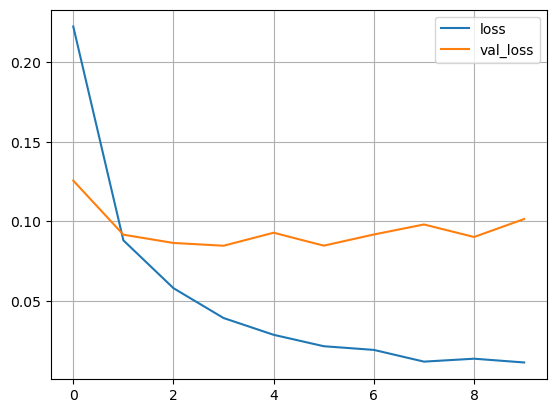

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

print(train_images.shape)

train_labels = np_utils.to_categorical(train_labels)
test_labels = np_utils.to_categorical(test_labels)

model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation="softmax"))

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

train_log = model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_split=0.2,
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

## Prequel - Saving and Loading Models

As we've seen, models can take a long time to train in many cases. Like with the sklearn models, we can save and load ours as they are trained and reused. This is a pretty integral part of making neural network models usable, so it is pretty easy. 

In addition to this we often see models saved in the h5 format, which just saves slightly less stuff along with the model. If we are using models trained elsewhere this format is very common. 

In [4]:
# Save my model
model.save('model_path')
model = keras.models.load_model('model_path')

INFO:tensorflow:Assets written to: model_path/assets


INFO:tensorflow:Assets written to: model_path/assets


In [5]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("model_path/my_h5_model.h5")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("model_path/my_h5_model.h5")

## Network Size

Probably the first question that we will think of when building networks through Tensorflow is "how big should it be"? This is a very big question, and one of those ones without a real answer. We can put some guidelines in place to help us though. 

### What Does the Size Mean?

The size of a neural network is also known as the capacity. We can relate it roughly to the size of our first model, the tree. The larger a network is the higher its capacity to learn. This is similar to a tree, the larger the tree, the more fitted it can become to the training data. 

### What Size to Use?

We can start with a few guidelines to have a reasonably sized neural network. These steps do not ensure an optimal solution, but they'll get us started. There really is not a prescribed method for calculating the optimal network size (beleive me, I've looked), but there are several rules of thumb we can build together to get a rough estimate of a starting point for sizing:

<ul>
<li> Start with an input layer that is either
    <ul>
    <li> The width of the data, if the feature set is relatively small. 
    <li> A reasonably large number if the feature set is large. 
    <li> We don't have a true diving line, but 512 is a reasonable value to try for an upper end, at least at first. 
    </ul>
<li> Add 1 or 2 hidden layers of the same size and observe the results. We want to keep the model smaller if making it larger doesn't improve things, so first we shoudl see how good of a job a small model does. If the data is very large, skipping past the 1 layer step may save some time since we can predict that we can do better with a larger model in advance. 
<li> Increase layers of the same size until we get some overfitting and the training loss flattens. We want to reach the point where the model is getting to be excellent at predicting the training data. This is something we can see in the plot by noticing that the validation loss flatlines or starts to get worse. The training loss flattening is an indication that the model is not getting any better at learning the training data; we can use early stopping with a loose patience setting on training loss and lots of epochs to find this. 
<li> Add regularization steps to cut down that overfitting. We can try regularization and dropouts to cut down on that overfitting. We probably want to try a few options, parameters, and combinations here, there's not really a way to know in advance which regularization will work best on our data. 
<li> Do a test of "funneling" the layer size, potentially adding more layers. The traditional configuration of layers is to gradually decrease the size from the input layer towards the output layer. There is open debate on if this is better than having layers that are all the same size. We can play with this a little to see if results improve or not. 
<li> Use pruning. Much like a tree we can prune back a model to fight overfitting. 
</ul>

### Height vs Width

Another begged question is should we make networks wider (more neurons) or deeper (more layers)? To that effect, we can also think about what happens as layers are added. Each layer allows the network to learn a different representation of the data, and if we flash back to the simple logistic regression and XOR examples, each layer allows the model to capture relationships that are more complex:
<ul>
<li> No hidden layers - linear relationships only. 
<li> 1 or more hidden layers - nonlinear relationships, of increasing complexity.
</ul>

So the number of layers in our model directly relates to the complexity of relationships that we can capture. This doesn't directly mean that more layers are better, but it generally means that we want the number of layers to mirror the "complexity" of the data, though complexity is a term with no exact definition or metric here. Once again, there's no universal answer on the balance between width of layers and number of layers, but the general evidence leans towards more layers. There are several reasons for this, none of them definitive, but taken as a whole they add up to a strong case:

<ul>
<li> Ability to learn different representation of the data - this will be more clear next time when we start to look at some image specific neural networks, but one of the cool features of neural networks is that at each layer the network "sees" a different representation of the data, as it goes through each round of transformations. This has the effect of allowing it to identify different features at each layer, and use those features to make more and more accurate predictions. We'll examine this more soon. 
<li> Avoiding overfitting - extremely wide neural networks tend towards overfitting the training data and not generalizing as well to new data. 
<li> Ability to add interim steps - with a multi layer network we can add multiple steps such as regularization or dropouts, again to fight overfitting. 
<li> Automatic feature selection - deep neural networks will automatically perform a type of feature selection as the least important features are minimized in their importance. This is an emerging area of research - some people have argued that well designed neural networks can remove the need for feature selection, and neural networks are being created to be feature selection tools. We can see this illustrated most clearly with images again, we feed a network an entire image, and get a prediction. Note that this isn't a total rejection of feature selection for neural networks, improving the feature set will impact neural network models just as it will for ordinary models; with neural networks we just have the potential for the network to "cover for mistakes" in the features. This is more dramatic as data size and network size increase. 
<li> Results - deep learning has become a common term recently for a reason, due to the success of deep neural networks with many layers. Most of the cool stuff that we see coming from AI such as image recognition, translation, and self navigating robots are the result of deep learning networks. In practice these networks have tended to outperform shallower ones, especially in more complex tasks. 
</ul>

### Overfitting and Underfitting

Why not make a model that is both very wide and very deep? This will tend to overfit as it can "memorize" the training data. With large datasets we do see very large models in some cases, since the more data we have, the more fitting we can handle. With large datasets and huge models, the training time can potentially explode, so we have to be careful. This is similar to what we saw with unlimited size in trees, we can eventually create a model large enough to memorize the training data. On the whole, the model capacity can be thought of similarly to the size of a tree. If we have large amounts of complex data, we want a model that has a very high capacity, as the relationships are complicated and we have enough data to mitigate overfitting. If we have smaller or more simple data, we want a smaller model, as a large one will overfit our data. 

Finding the "optimal" size is still somewhat of an art, combined with patience for trial and error. <b>The easiest starting point is probably to create a model that can potentially overfit, though not comically large, then use some regularization techniques and early stopping to find the optimal fit.</b> We should also note that it is possible and reasonable that models of different sizes and configurations tend to converge on similar levels of performace. These neural networks are extremely flexible in how they learn during the training process, so they can "learn around" some degree of design decisions in a way that is more dramatic than our previous models. 

Epoch 1/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2250 - accuracy: 0.9309 - val_loss: 0.1217 - val_accuracy: 0.9620
Epoch 2/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1070 - accuracy: 0.9666 - val_loss: 0.1066 - val_accuracy: 0.9692
Epoch 3/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0853 - accuracy: 0.9737 - val_loss: 0.0946 - val_accuracy: 0.9721
Epoch 4/100
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0695 - accuracy: 0.9787 - val_loss: 0.0933 - val_accuracy: 0.9742
Epoch 5/100
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0581 - accuracy: 0.9820 - val_loss: 0.0951 - val_accuracy: 0.9743
Epoch 6/100
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0519 - accuracy: 0.9836 - val_loss: 0.0921 - val_accuracy: 0.9769
Epoch 7/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0496 - accuracy: 0.9846 - val_loss: 0.1158 - v

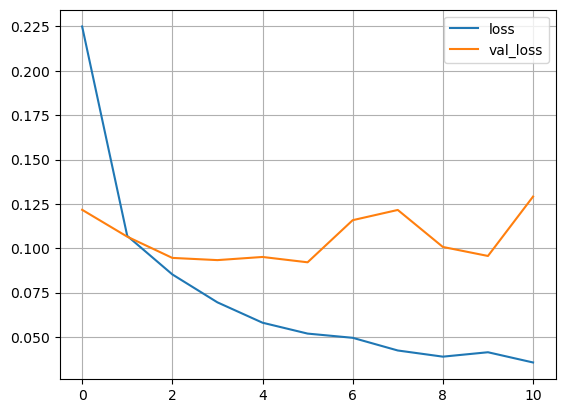

In [6]:
# Model
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

train_log = model.fit(
  train_images,
  train_labels,
  epochs=100,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

In [7]:
# Bigger Model
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

train_log = model.fit(
  train_images,
  train_labels,
  epochs=100,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

Epoch 1/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2871 - accuracy: 0.9134 - val_loss: 0.1562 - val_accuracy: 0.9554
Epoch 2/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1530 - accuracy: 0.9570 - val_loss: 0.1137 - val_accuracy: 0.9667
Epoch 3/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1197 - accuracy: 0.9669 - val_loss: 0.1153 - val_accuracy: 0.9689
Epoch 4/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1025 - accuracy: 0.9712 - val_loss: 0.1107 - val_accuracy: 0.9707
Epoch 5/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0907 - accuracy: 0.9753 - val_loss: 0.0977 - val_accuracy: 0.9747
Epoch 6/100
 708/1500 [=============>................] - ETA: 4s - loss: 0.0783 - accuracy: 0.9781

KeyboardInterrupt: 

Epoch 1/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3815 - accuracy: 0.8892 - val_loss: 0.1902 - val_accuracy: 0.9459
Epoch 2/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1722 - accuracy: 0.9550 - val_loss: 0.1276 - val_accuracy: 0.9660
Epoch 3/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1339 - accuracy: 0.9655 - val_loss: 0.1143 - val_accuracy: 0.9712
Epoch 4/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1110 - accuracy: 0.9717 - val_loss: 0.1075 - val_accuracy: 0.9728
Epoch 5/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0984 - accuracy: 0.9750 - val_loss: 0.1050 - val_accuracy: 0.9740
Epoch 6/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0873 - accuracy: 0.9771 - val_loss: 0.1058 - val_accuracy: 0.9747
Epoch 7/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0776 - accuracy: 0.9798 - val_loss: 0.0881 - val_ac

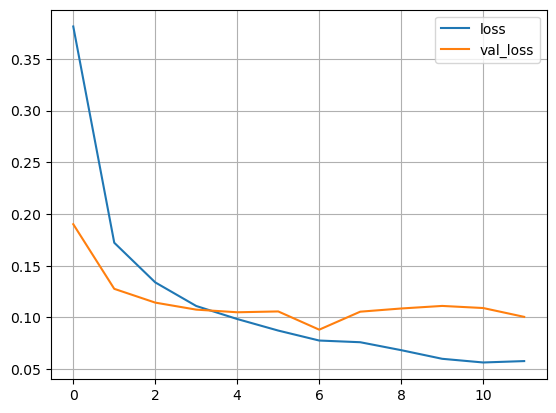

In [ ]:
# Tapered Model
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

train_log = model.fit(
  train_images,
  train_labels,
  epochs=100,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

## Epochs and Batch Sizes

![Batch Sizes](images/iterations_epoch.webp "Batch Sizes")

### Epochs

Each epoch is a run through all of the training data. Epochs are simple, we can set a large number and use early stopping to cut things off when we've reached the best result. 

### Batch Sizes

Batch size determines how many records are processed before the gradients are updated - i.e. the number of records between one forward and backwards pass. The batch sizes are a matter of very open debate for the optimal solution. At the high end, batch sizes are limited by what can fit in memory. When dealing with very large data this may matter as a batch that is a small fraction of the data may be a massive absolute size. At the lower end using smaller batches gives the same effect as it does when we looked at regular gradient descent - the gradients become less stable as we are relying on a smaller number of records. In reading more about batch sizes I want to update my recommendation to be even smaller than the 50 to 150 I suggested before, down to less than 100, even as small as into the single digits. There is research that smaller batch sizes tend to produce models that generalize better than ones with larger batches. 

Larger batch sizes do tend to be processed more quickly, sometimes substantially so, as the hardware is better able to be "saturated" with data to process. In big data scenarios, this can matter. One thing that you see in practice is that the GPUs (or similar) that are used to train neural networks have a certain amount of memory, and the batch size is limited by that memory. When doing something that involves large images or video, or similar, this can be a real area for concern. For us, these constraints won't really come up, but it's good to be aware of them. 

Dont' stress too much on batch size, this is really something that needs to be grid searched to find a great answer and in scenarios where it actually matters, is largely influenced by the hardware that is available.

Epoch 1/100
10/10 [==============================] - 1s 58ms/step - loss: 1.3769 - accuracy: 0.6282 - val_loss: 0.4761 - val_accuracy: 0.8654
Epoch 2/100
10/10 [==============================] - 0s 49ms/step - loss: 0.4748 - accuracy: 0.8557 - val_loss: 0.3058 - val_accuracy: 0.9145
Epoch 3/100
10/10 [==============================] - 0s 50ms/step - loss: 0.3443 - accuracy: 0.8989 - val_loss: 0.2441 - val_accuracy: 0.9285
Epoch 4/100
10/10 [==============================] - 1s 53ms/step - loss: 0.2684 - accuracy: 0.9211 - val_loss: 0.2009 - val_accuracy: 0.9409
Epoch 5/100
10/10 [==============================] - 1s 53ms/step - loss: 0.2248 - accuracy: 0.9344 - val_loss: 0.1758 - val_accuracy: 0.9507
Epoch 6/100
10/10 [==============================] - 1s 56ms/step - loss: 0.1941 - accuracy: 0.9439 - val_loss: 0.1585 - val_accuracy: 0.9547
Epoch 7/100
10/10 [==============================] - 1s 63ms/step - loss: 0.1702 - accuracy: 0.9494 - val_loss: 0.1440 - val_accuracy: 0.9593
Epoch 

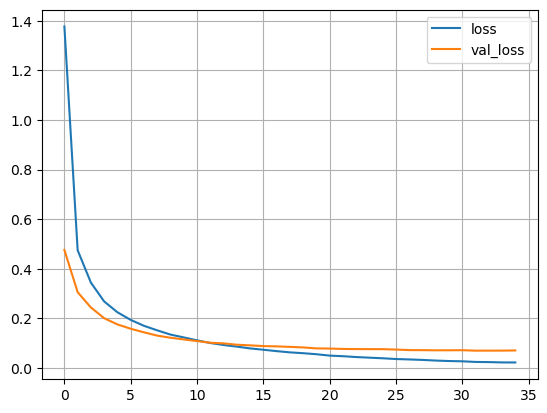

In [ ]:
# Big Batch
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

train_log = model.fit(
  train_images,
  train_labels,
  epochs=100,
  batch_size=5000,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

Epoch 1/300
24000/24000 [==============================] - 53s 2ms/step - loss: 0.3020 - accuracy: 0.9150 - val_loss: 0.2201 - val_accuracy: 0.9416
Epoch 2/300
24000/24000 [==============================] - 47s 2ms/step - loss: 0.2189 - accuracy: 0.9455 - val_loss: 0.1836 - val_accuracy: 0.9528
Epoch 3/300
24000/24000 [==============================] - 47s 2ms/step - loss: 0.2135 - accuracy: 0.9518 - val_loss: 0.1743 - val_accuracy: 0.9672
Epoch 4/300
24000/24000 [==============================] - 46s 2ms/step - loss: 0.2083 - accuracy: 0.9542 - val_loss: 0.1937 - val_accuracy: 0.9653
Epoch 5/300
24000/24000 [==============================] - 46s 2ms/step - loss: 0.2057 - accuracy: 0.9569 - val_loss: 0.1727 - val_accuracy: 0.9685
Epoch 6/300
24000/24000 [==============================] - 48s 2ms/step - loss: 0.2048 - accuracy: 0.9585 - val_loss: 0.2042 - val_accuracy: 0.9689
Epoch 7/300
24000/24000 [==============================] - 47s 2ms/step - loss: 0.2028 - accuracy: 0.9583 - val_

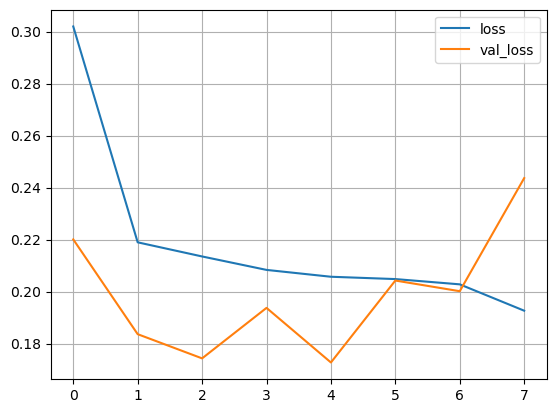

In [ ]:
# Small Batch
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

# Note: Batch size of 2 is good to test
# But it can take a VERY long time, be aggressive with the early stopping
train_log = model.fit(
  train_images,
  train_labels,
  epochs=300,
  batch_size=2,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

## Optimizer

Of all options the optimizer is the one we will care about the least. Each different optimizer is a different algorithm for doing the gradient descent. The optimizers have different results with respect to speed, memory usage, computational expense, and likelyhood to get stuck in a local minima. The optimizer is similar to some of the options we saw with logistic regression - there were several solver options for that model, each of which performed the gradient descent process with a slightly different set of calculations. Optimizers tend to manipulate the learning rate, attempting to narrow in on the optimum weights in fewer epochs and thus fewer calculations.

![Optimizers](images/optimizers.gif "Optimizers")

<b>Note:</b> this animation doesn't have Adam, which is unfortumate, but it was the most clear one I could find. The different optimizers are all trying to find the same minimum, and in most cases they all do, but they take differnt paths to get there, over a different number of steps.

Adam is a good compromise between all factors and is very commonly used. We'll just use this for our work. One other common one is RMSprop, if you're feeling spicy, give that a try and see if there are any imporvements. These optimizers don't change the model we are making (outside of edge cases, like getting stuck in a minima), they change the process of finding that model. The biggest impact of the optimizer is on the speed of the training process, and in turn the ability to experiment with different models. This is more of a concern as the data gets larger, as small improvements on each individual gradient descent step can add up to large improvements in the overall training time. 

In [ ]:
optimizer_1 = tf.keras.optimizers.Adam()
optimizer_2 = tf.keras.optimizers.RMSprop()

## Activation 

Activation functions are the key to adding non-linearity to the network allowing it to learn complex and non-linear relationships in the data. We've used ReLU as the default and that is a solid choice in most cases. ReLU has one issue, the dying ReLU problem. This can happen when we get inputs to the activation function fall in the negative area. In short there can be neurons that "die" and never get updated again because the value becomes 0 and stays 0. These dead neurons are a problem as they now aren't contributing to the learning.

![ReLU](images/relu.jpeg "ReLU")

To combat the dying ReLU problem there are a couple of other activation functions that avoid that issue - Leaky ReLU and ELU. Each one changes the negative values to something other than 0 - Leaky ReLU uses a slight linear gradient, ELU uses an exponential function for a similar, but curved, slight gradient. These ReLU variants are a good choice, and probably the 'best' overall activation functions for most scenarios. One some datasets will be impacted by the dying ReLU problem. 

These activation function also have an impact on the speed of training. The ReLU function is very fast to calculate, and the Leaky ReLU and ELU functions are a bit slower. Other activation functions may be even more expensive. Will this matter? As with many things, it depends. For the small examples we are using, it probably won't matter much. On very large applications, we may need to consider the ability to train models more quickly, and try more models vs. the improved fit of another activation function.

#### Activation Function Guidelines

We can write a few rules of thumb to guide us in deciding on activation functions. On the whole, the choice is like a hyperparameter choice, and we want to choose whichever is the best for our data. Some of the guidelines are:
<ul>
<li> The output layer should have an activation function that matches the type of problem we are solving. 
    <ul>
    <li> <b>Regression:</b> Linear activation function.
    <li> <b>Binary Classification:</b> Sigmoid activation function.
    <li> <b>Multiclass Classification:</b> Softmax activation function.
    </ul>
<li> Depending on the type of network/problem, our hidden layers default to different activation functions:
    <ul>
    <li> <b>Deep Neural Networks:</b> ReLU activation functions.
    <li> <b>Convolutional Neural Networks: (Images)</b> ReLU activation functions.
    <li> <b>Recurrent Neural Networks:(Seqential, Time Series)</b> Tanh activation function.
    </ul>
</ul>

There are more activation functions, and others are being developed somewhat regularly. If in doubt, just use a ReLU variant. 

Epoch 1/10
750/750 [==============================] - 3s 3ms/step - loss: 0.2742 - accuracy: 0.9152 - val_loss: 0.1390 - val_accuracy: 0.9590
Epoch 2/10
750/750 [==============================] - 2s 3ms/step - loss: 0.1414 - accuracy: 0.9574 - val_loss: 0.1277 - val_accuracy: 0.9630
Epoch 3/10
750/750 [==============================] - 2s 3ms/step - loss: 0.1098 - accuracy: 0.9672 - val_loss: 0.1226 - val_accuracy: 0.9646
Epoch 4/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0962 - accuracy: 0.9718 - val_loss: 0.1139 - val_accuracy: 0.9672
Epoch 5/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0858 - accuracy: 0.9743 - val_loss: 0.0950 - val_accuracy: 0.9743
Epoch 6/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0802 - accuracy: 0.9757 - val_loss: 0.1005 - val_accuracy: 0.9730
Epoch 7/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0715 - accuracy: 0.9791 - val_loss: 0.1006 - val_accuracy: 0.9742
Epoch 

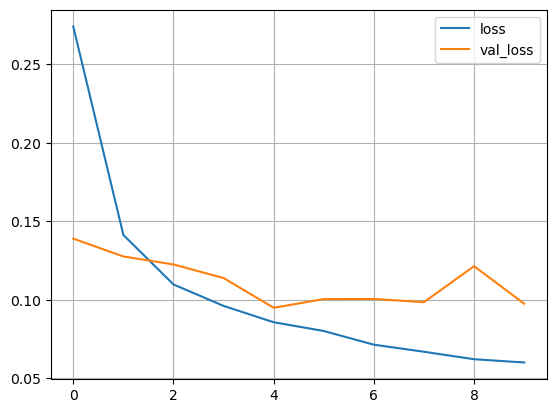

In [ ]:
# Take a leak 
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Dense(350, activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 

# Train the digit classification model
model.compile(optimizer=optimizer_2, loss="categorical_crossentropy", metrics='accuracy')

train_log = model.fit(
  train_images,
  train_labels,
  epochs=10,
  batch_size=64,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

## Batch Normalization

Batch normalization is a technique that is used to normalize the inputs of each layer, so that the network can learn more quickly and with more stability. This is a technique that is used to help with the vanishing gradient problem, which is a problem that can occur when the gradients become very small and the network stops learning. This is a common problem with deep networks, and batch normalization is a common solution.

Using batch normalization can have a few effects on the network:
<ul>
<li> Faster training - the network can learn more quickly with batch normalization.
<li> More stable training - the network is less likely to get stuck in a local minima.
<li> Regularization - batch normalization can act as a form of regularization, helping to prevent overfitting.
</ul>

Batch normalization is a good choice for many networks, and we see it used very commonly in practice. It is unlikely to make things worse. Implementing batch normalization is as simple as adding a layer to the network. In most cases we can add it after the activation function, meaning after a dense layer here. It can be done at other points, such as before the activation layer, if it is separated from the dense layer - this is more of a fine-tuning concern. 

Epoch 1/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3746 - accuracy: 0.8929 - val_loss: 1.8112 - val_accuracy: 0.3566
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.2017 - accuracy: 0.9427 - val_loss: 1.1541 - val_accuracy: 0.7108
Epoch 3/100
96/96 [==============================] - 1s 9ms/step - loss: 0.1472 - accuracy: 0.9586 - val_loss: 0.6243 - val_accuracy: 0.8037
Epoch 4/100
96/96 [==============================] - 1s 9ms/step - loss: 0.1114 - accuracy: 0.9693 - val_loss: 0.2897 - val_accuracy: 0.9233
Epoch 5/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0886 - accuracy: 0.9760 - val_loss: 0.1585 - val_accuracy: 0.9567
Epoch 6/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0696 - accuracy: 0.9815 - val_loss: 0.1161 - val_accuracy: 0.9671
Epoch 7/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0561 - accuracy: 0.9858 - val_loss: 0.1052 - val_accuracy: 0.9682
Epoch 8/100

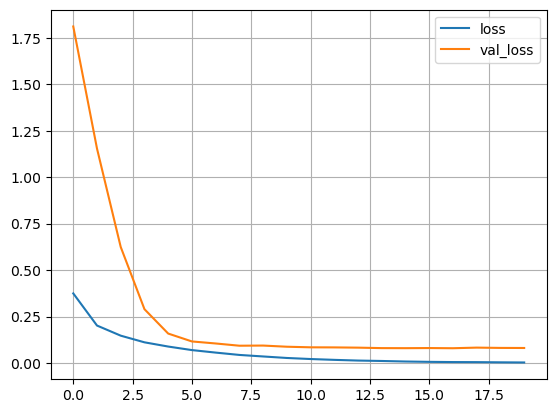

In [ ]:
# with sigmoid
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(350, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(10, activation="softmax"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

train_log = model.fit(
  train_images,
  train_labels,
  epochs=100,
  batch_size=500,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

Epoch 1/100
96/96 [==============================] - 1s 10ms/step - loss: 0.2454 - accuracy: 0.9267 - val_loss: 0.6515 - val_accuracy: 0.9370
Epoch 2/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0679 - accuracy: 0.9812 - val_loss: 0.2852 - val_accuracy: 0.9571
Epoch 3/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0333 - accuracy: 0.9914 - val_loss: 0.1309 - val_accuracy: 0.9675
Epoch 4/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0179 - accuracy: 0.9962 - val_loss: 0.0888 - val_accuracy: 0.9745
Epoch 5/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0103 - accuracy: 0.9981 - val_loss: 0.0830 - val_accuracy: 0.9756
Epoch 6/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0056 - accuracy: 0.9993 - val_loss: 0.0820 - val_accuracy: 0.9773
Epoch 7/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.0833 - val_accuracy: 0.9766
Epoch 8/100


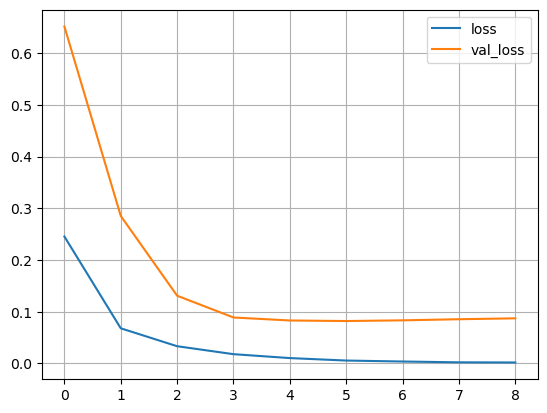

In [ ]:
# With ReLU
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(350, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation="softmax"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

train_log = model.fit(
  train_images,
  train_labels,
  epochs=100,
  batch_size=500,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_images, test_labels)
plot_loss(train_log)

## Initialization

The initialization provides the starting point for all the weights and bias values that we start out with. We initially started with random values in the scratch network - this is generally fine, but we can sometimes do better. One specific case where we can do better is when we have data that is highly imbalanced. This is a common problem in things such as fraud detection, where we have a very small number of fraud cases, and a very large number of non-fraud cases. Seeding the model with an "expectation" of the bias values can help the model learn faster and converge on an answer more quickly. In cases where we have a lot of data, this can be a big deal. In cases where we may have local minima in the loss curve, this can be significant - the more "ground" the gradient descent covers, the greater the odds it encounters a local minima that might be a trap. With imbalanced data, we expect that the model will need to cover a lot of that ground, so starting off with a better bias value can help. 

### Imbalanced Weighting

One application where initialization can help significantly is when dealing with imbalanced data. In this example of credit card fraud (real data that has been put through PCA), very, very few transactions are fraudulent. So we have a very imbalanced target value - the class variable. 

In [ ]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Count the Target Outcomes

Credit card fraud is relatively rare, at least in view of the total number of transactions. We can count up the target values to see exactly what the expected skew is. 

In [ ]:
# Bincount will count the number in each category
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### We Have an Imbalance

A big one. 

In [ ]:
# pop just removes a column. The equivalent of how we normally drop. 
# the TF docs commonly use this, so I've left it as is. 
cleaned_df = raw_df.copy()
# You don't want the `Time` column.
cleaned_df.pop('Time')

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [ ]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

#train_features = np.clip(train_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

print('Training features shape:', train_features.shape)
print('Training labels shape:', train_labels.shape)
print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (227845, 29)
Training labels shape: (227845,)
Test features shape: (56962, 29)
Test labels shape: (56962,)


### Create a Biased Model

The bias of the data is inserted in the model compilation step on the output layer. What does this do? It preconfigures the output layer to "expect" results to be this skewed. Recall that, along with the weight, the bias values are one of the things that is learned in training. By default the initial values are randomized, so the model needs to learn the skew towards the imbalance - if the balance between classes is moderate, that's not a big deal; if the balance is so drastically skewed in one direction, that's less practical. With the preset bias we can speed convergance and likely reduce loss. 

#### Other Imbalenced Work

Other things that we looked at to improve balance such as under/over sampling still works with neural networks as it would with anything else. This is just one nn-specific thing that we can implement with minimal extra work. 

#### Metrics

We can also add a bunch of metrics to what we get returned by creating a list of the metrics that we want. Keras.metrics has a list, they are all the metrics we might expect. 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 16)                480       
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
2849/2849 [==============================] - 2s 521us/step - loss: 0.0078 - precision: 0.7441 - recall: 0.4787 - auc: 0.8584 - prc: 0.5039 - val_loss: 0.0043 - val_precision: 0.8864 - val_recall: 0.5493 - val_auc: 0.9292 - val_prc: 0.7288
Epoch 2/30
2849/2849 [==============================] - 1s 431us/step - loss: 0.0051 - precision: 0.8773 - recall: 0.5884 - auc: 0.9229 - prc: 0.7001 - val_loss: 0.0040 - val_precision: 0.8913 - val_recall: 0.5775 - val_auc: 0.9363 - val_prc: 0.7347
Epoch 3/30
2849/2849 [==============================] - 1s 433us/step - loss: 0.0051 - precision: 0.8784 - recall: 0.5945 - auc: 0.9184 - prc: 0.6942 - val_loss: 0.0039 - val_precision: 0.8718 - val_recall: 0.4789 - val_auc: 0.9364 - val_prc: 0.7398
Epoch 4/30
2849/2849 [==============================] - 1s 431us/step - loss: 0.0047 - precision: 0.8468 - recall: 0.5732 - auc: 0.9290 - prc: 0.7112 - val_loss: 0.0036 - val_precision: 0.8889 - val_recall: 0.5634 - val_auc: 0.9364 - val_prc: 0.7384


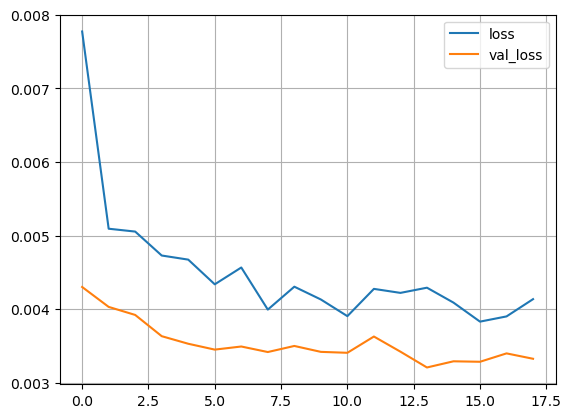

In [ ]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

initial_bias = np.log([pos/neg])

output_bias = tf.keras.initializers.Constant(initial_bias)
model = keras.Sequential()
model.add(keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) 

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=metrics)
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=METRICS)
#Fit
train_log = model.fit(
  train_features,
  train_labels,
  epochs=30,
  batch_size=64,
  validation_split=0.2,
  callbacks=[callback]
)
model.evaluate(test_features, test_labels)
plot_loss(train_log)

### Model Structure and Tuning

We'll look at tuning neural network models in more depth soon. For now, we can use the results of our model's training and validation scores, along with a few guidelines, to aim us in the correct direction for making a good model. 

Some guidelines for tuning neural networks are:
<ul>
<li> Start with something small-ish, and increase as needed. For our exercises, this likely means 2 or 3 hidden layers to start. </li>
<li> Use early stopping to find the optimal number of epochs. </li>
<li> If the training score is similar to the validation score, the model is probably underfitting. Try things to allow it to learn more:</li>
    <ul>
    <li> Increasing the number of layers. </li>
    <li> Increasing the number of neurons in each layer. </li>
    <li> Training for more epochs. </li>
    </ul>
<li> If the training score is much higher than the validation score, the model is probably overfitting. Try things to prevent it from learning too much:</li>
    <ul>
    <li> Adding regularization. </li>
    <li> Adding dropout. </li>
    <li> Reducing the number of layers or the size of the layers. </li>
    </ul>
<li> If the model's scores seem to flatline, try adding some batch normalization or changing some other optimization-ish option. </li>
</ul>

These are just guidelines, but they are a good starting point. 

## Exercise

Predict the price of diamonds! (The example solutions are fairly extreme in terms of the approach they take, you'll probably be ok with less dramatic approaches.)

![Diamonds](images/diamonds.jpeg "Diamonds" )

In [ ]:
ex_df = sns.load_dataset("diamonds")
ex_df = pd.get_dummies(ex_df)

ex_df.head()

,carat,depth,table,price,x,y,z,cut_Ideal,cut_Premium,cut_Very Good,...,color_I,color_J,clarity_IF,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
0,0.23,61.5,55.0,326,3.95,3.98,2.43,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,True,False,...,True,False,False,False,False,False,True,False,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,False,False,False,...,False,True,False,False,False,False,False,False,True,False


In [ ]:
y = np.array(ex_df["price"]).astype(np.float32)
X = np.array(ex_df.drop(columns={"price"})).astype(np.float32)
X_tr_ex, X_te_ex, y_tr_ex, y_te_ex = train_test_split(X, y)
start_width = X.shape[1]
start_width

26

In [ ]:
ex_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carat,53940.0,NaN,NaN,NaN,0.79794,0.474011,0.2,0.4,0.7,1.04,5.01
depth,53940.0,NaN,NaN,NaN,61.749405,1.432621,43.0,61.0,61.8,62.5,79.0
table,53940.0,NaN,NaN,NaN,57.457184,2.234491,43.0,56.0,57.0,59.0,95.0
price,53940.0,NaN,NaN,NaN,3932.799722,3989.439738,326.0,950.0,2401.0,5324.25,18823.0
x,53940.0,NaN,NaN,NaN,5.731157,1.121761,0.0,4.71,5.7,6.54,10.74
y,53940.0,NaN,NaN,NaN,5.734526,1.142135,0.0,4.72,5.71,6.54,58.9
z,53940.0,NaN,NaN,NaN,3.538734,0.705699,0.0,2.91,3.53,4.04,31.8
cut_Ideal,53940,2,False,32389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cut_Premium,53940,2,False,40149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cut_Very Good,53940,2,False,41858,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Generate a Baseline

I'll use a different loss - mean absolute percentage. 

422/422 [==============================] - 0s 233us/step - loss: 9.4137
9.413739204406738


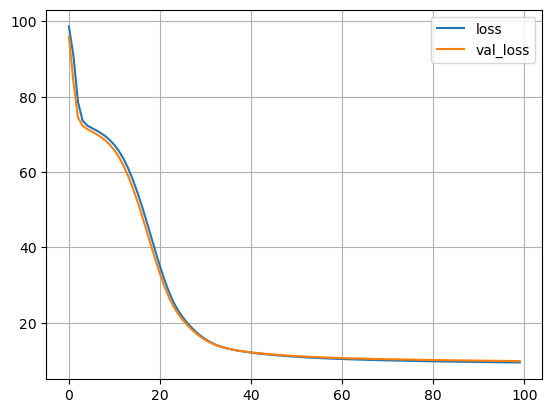

In [ ]:
#baseline
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_tr_ex))

mod_ex = keras.Sequential()
mod_ex.add(normalizer)
mod_ex.add(InputLayer(input_shape=(start_width,)))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(1))

mod_ex.compile(optimizer='adam', loss="mean_absolute_percentage_error")

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True) 

hist_ex = mod_ex.fit(
  X_tr_ex,
  y_tr_ex,
  epochs=100,
  batch_size=64,
  validation_split=0.2,
  callbacks=[callback],
  verbose=0
)
print(mod_ex.evaluate(X_te_ex, y_te_ex))
plot_loss(hist_ex)

### Attempt Optimization

Looks like lots of loss! What to do?

Things to try:
<ol>
<li> Depth.
<li> Width. 
<li> Activations. 
<li> Batches. 
</ol>

422/422 [==============================] - 0s 309us/step - loss: 6.4728
6.47279167175293


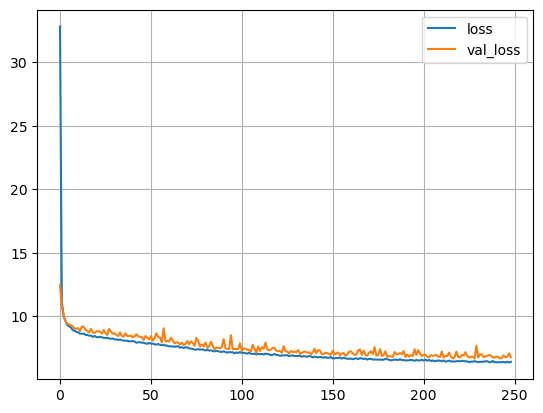

In [ ]:
#Comically Deep Model
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_tr_ex))

mod_ex = keras.Sequential()
mod_ex.add(normalizer)
mod_ex.add(InputLayer(input_shape=(start_width,)))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(1))

mod_ex.compile(optimizer='adam', loss="mean_absolute_percentage_error")

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) 

hist_ex = mod_ex.fit(
  X_tr_ex,
  y_tr_ex,
  epochs=1000,
  batch_size=64,
  validation_split=0.2,
  callbacks=[callback],
  verbose=0
)
print(mod_ex.evaluate(X_te_ex, y_te_ex))
plot_loss(hist_ex)

##### Try Adding Dropouts

We don't have a bunch of overfitting, so we may not expect miracles here... 

422/422 [==============================] - 0s 280us/step - loss: 43.5719
43.57194519042969


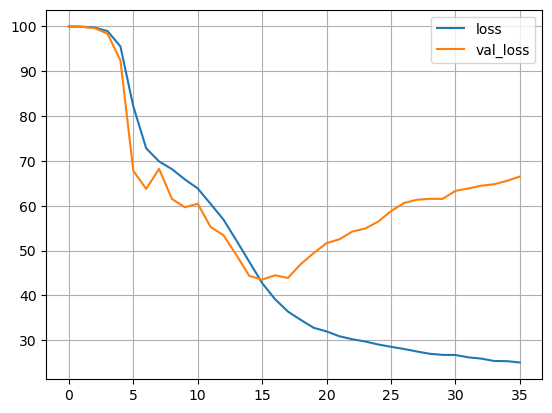

In [ ]:
#Comically Deep Model with Dropouts
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_tr_ex))

mod_ex = keras.Sequential()
mod_ex.add(normalizer)
mod_ex.add(InputLayer(input_shape=(start_width,)))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(1))

mod_ex.compile(optimizer='adam', loss="mean_absolute_percentage_error")

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) 

hist_ex = mod_ex.fit(
  X_tr_ex,
  y_tr_ex,
  epochs=200,
  batch_size=4048,
  validation_split=0.2,
  callbacks=[callback],
  verbose=0
)
print(mod_ex.evaluate(X_te_ex, y_te_ex))
plot_loss(hist_ex)

##### Taper Model Somewhat

Epoch 1/1000
506/506 [==============================] - 1s 735us/step - loss: 54.4815 - mean_squared_error: 18469084.0000 - mean_absolute_error: 2539.8125 - mean_absolute_percentage_error: 54.4815 - val_loss: 16.0361 - val_mean_squared_error: 2205936.7500 - val_mean_absolute_error: 687.8245 - val_mean_absolute_percentage_error: 16.0361
Epoch 2/1000
506/506 [==============================] - 0s 567us/step - loss: 13.2684 - mean_squared_error: 1592866.1250 - mean_absolute_error: 574.2430 - mean_absolute_percentage_error: 13.2684 - val_loss: 12.1257 - val_mean_squared_error: 1523874.1250 - val_mean_absolute_error: 514.1353 - val_mean_absolute_percentage_error: 12.1257
Epoch 3/1000
506/506 [==============================] - 0s 565us/step - loss: 11.3960 - mean_squared_error: 1303480.6250 - mean_absolute_error: 501.6617 - mean_absolute_percentage_error: 11.3960 - val_loss: 11.3132 - val_mean_squared_error: 1300195.7500 - val_mean_absolute_error: 463.3058 - val_mean_absolute_percentage_error

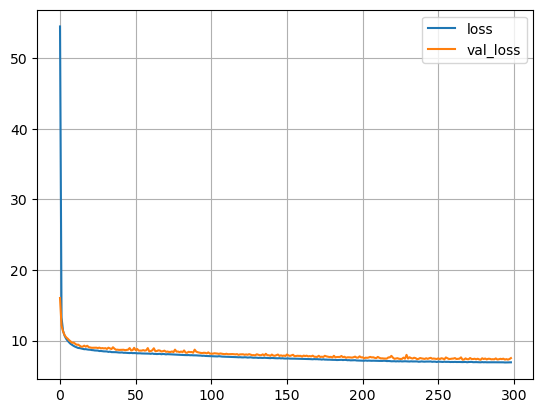

In [ ]:
#Taper Deep Model
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_tr_ex))

mod_ex = keras.Sequential()
mod_ex.add(normalizer)
mod_ex.add(InputLayer(input_shape=(start_width,)))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width/2, activation='relu'))
mod_ex.add(Dense(start_width/2, activation='relu'))
mod_ex.add(Dense(start_width/3, activation='relu'))
mod_ex.add(Dense(start_width/3, activation='relu'))
mod_ex.add(Dense(start_width/4, activation='relu'))
mod_ex.add(Dense(1))

mod_ex.compile(optimizer='adam', loss="mean_absolute_percentage_error", metrics=[metrics.mean_squared_error, 
                                                                        metrics.mean_absolute_error, 
                                                                        metrics.mean_absolute_percentage_error])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) 

hist_ex = mod_ex.fit(
  X_tr_ex,
  y_tr_ex,
  epochs=1000,
  batch_size=64,
  validation_split=0.2,
  callbacks=[callback],
  verbose=1
)
print(mod_ex.evaluate(X_te_ex, y_te_ex))
plot_loss(hist_ex)

#### Best Trial

This may vary a bit, but what I saw in the results above was broadly:
<ul>
<li> Train and test results improved by adding layers. </li>
<li> Adding dropouts didn't help much. </li>
<li> Batch normalization helped a bit. </li>
<li> Tapering size down tended to help. </li>
</ul>

I tried a combo of those things to see the results. In general, this seemed to work best with a larger model, lots of training, and some normalization to keep it learning. There may be other structures that work just as well, or better, but from my trials, these patterns emerged from the results. I made a model to mirror that:
<ul>
<li> Start with a wide layer. </li>
<li> Taper the width down. </li>
<li> Have several layers (the model seemed to keep learning with more layers in previous trails)). </li>
<li> Add batch normalization. (The loss flatlined previously). </li>
<li> Allow for many epochs, until improvement stops. </li>
</ul>

Epoch 1/6000
6/6 [==============================] - 1s 34ms/step - loss: 99.9793 - val_loss: 99.9964
Epoch 2/6000
6/6 [==============================] - 0s 14ms/step - loss: 99.9419 - val_loss: 99.9925
Epoch 3/6000
6/6 [==============================] - 0s 13ms/step - loss: 99.9163 - val_loss: 99.9879
Epoch 4/6000
6/6 [==============================] - 0s 13ms/step - loss: 99.8935 - val_loss: 99.9806
Epoch 5/6000
6/6 [==============================] - 0s 13ms/step - loss: 99.8725 - val_loss: 99.9718
Epoch 6/6000
6/6 [==============================] - 0s 13ms/step - loss: 99.8536 - val_loss: 99.9618
Epoch 7/6000
6/6 [==============================] - 0s 13ms/step - loss: 99.8354 - val_loss: 99.9515
Epoch 8/6000
6/6 [==============================] - 0s 13ms/step - loss: 99.8187 - val_loss: 99.9416
Epoch 9/6000
6/6 [==============================] - 0s 13ms/step - loss: 99.8031 - val_loss: 99.9323
Epoch 10/6000
6/6 [==============================] - 0s 13ms/step - loss: 99.7888 - val_los

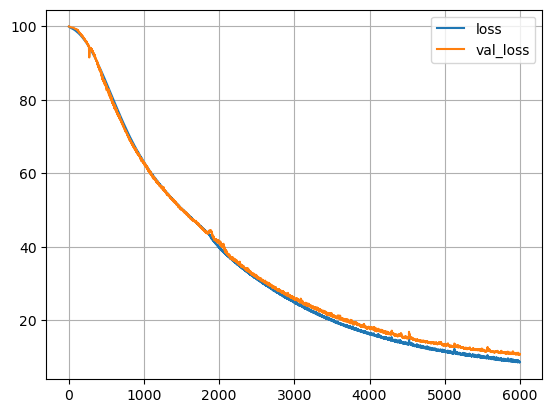

In [ ]:
# Best Guess 
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_tr_ex))

mod_ex = keras.Sequential()
mod_ex.add(normalizer)
mod_ex.add(InputLayer(input_shape=(start_width,)))
mod_ex.add(Dense(start_width*3, activation='relu'))
mod_ex.add(BatchNormalization())
#mod_ex.add(Dense(start_width*3, activation='relu'))
#mod_ex.add(BatchNormalization())
mod_ex.add(Dense(start_width*2, activation='relu'))
mod_ex.add(BatchNormalization())
#mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width*2, activation='relu'))
mod_ex.add(BatchNormalization())
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(BatchNormalization())
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(BatchNormalization())
#mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width/2, activation='relu'))
mod_ex.add(BatchNormalization())
#mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width/2, activation='relu'))
mod_ex.add(BatchNormalization())
#mod_ex.add(Dense(start_width/3, activation='relu'))
#mod_ex.add(BatchNormalization())
#mod_ex.add(Dropout(.2))
mod_ex.add(Dense(start_width/3, activation='relu'))
mod_ex.add(BatchNormalization())
mod_ex.add(Dense(start_width/4, activation='relu'))
mod_ex.add(BatchNormalization())
mod_ex.add(Dense(1))

mod_ex.compile(optimizer='adam', loss="mean_absolute_percentage_error")

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, restore_best_weights=True) 

hist_ex = mod_ex.fit(
  X_tr_ex,
  y_tr_ex,
  epochs=6000,
  batch_size=6000,
  validation_split=0.2,
  callbacks=[callback],
  verbose=1
)
print(mod_ex.evaluate(X_te_ex, y_te_ex))
plot_loss(hist_ex)